# Introverts - Extroverts Prediction Model

[Kaggle competition](https://www.kaggle.com/competitions/playground-series-s5e7/overview)

By: Adriana Villalobos

In [31]:
import pandas as pd
from funpymodeling.exploratory import freq_tbl, status
import numpy as np

In [32]:
# Dataframe import
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [33]:
pd.set_option('display.max_columns', None)

## 1. EDA

In [34]:
df_train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [36]:
status(df_train)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,id,0,0.000000,1,0.000054,18524,int64
1,Time_spent_Alone,1190,0.064241,3139,0.169456,12,float64
2,Stage_fear,1893,0.102192,0,0.000000,2,object
3,Social_event_attendance,1180,0.063701,1055,0.056953,11,float64
4,Going_outside,1466,0.079141,1324,0.071475,8,float64
5,Drained_after_socializing,1149,0.062028,0,0.000000,2,object
6,Friends_circle_size,1054,0.056899,467,0.025211,16,float64
7,Post_frequency,1264,0.068236,1272,0.068668,11,float64
8,Personality,0,0.000000,0,0.000000,2,object


In [37]:
# Duplicates handling
print(f"Total of duplicated: {df_train.duplicated().sum()}")
df_train = df_train.drop_duplicates()

Total of duplicated: 0


In [38]:
# Drop the id column
df_train = df_train.drop(['id'], axis=1)

In [39]:
# Mapping of columns with Yes/No values to numerical
map = {'No': 0, 'Yes': 1}
obj_cols = ['Stage_fear', 'Drained_after_socializing']
for col in obj_cols:  
    df_train[col] = df_train[col].map(map)
    df_test[col] = df_test[col].map(map)

In [40]:
# Mapping of target variable
df_train['Personality'] = df_train['Personality'].map({'Introvert': 0, 'Extrovert': 1})

In [41]:
from pandas_profiling import ProfileReport
ProfileReport(df_train, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 628.20it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

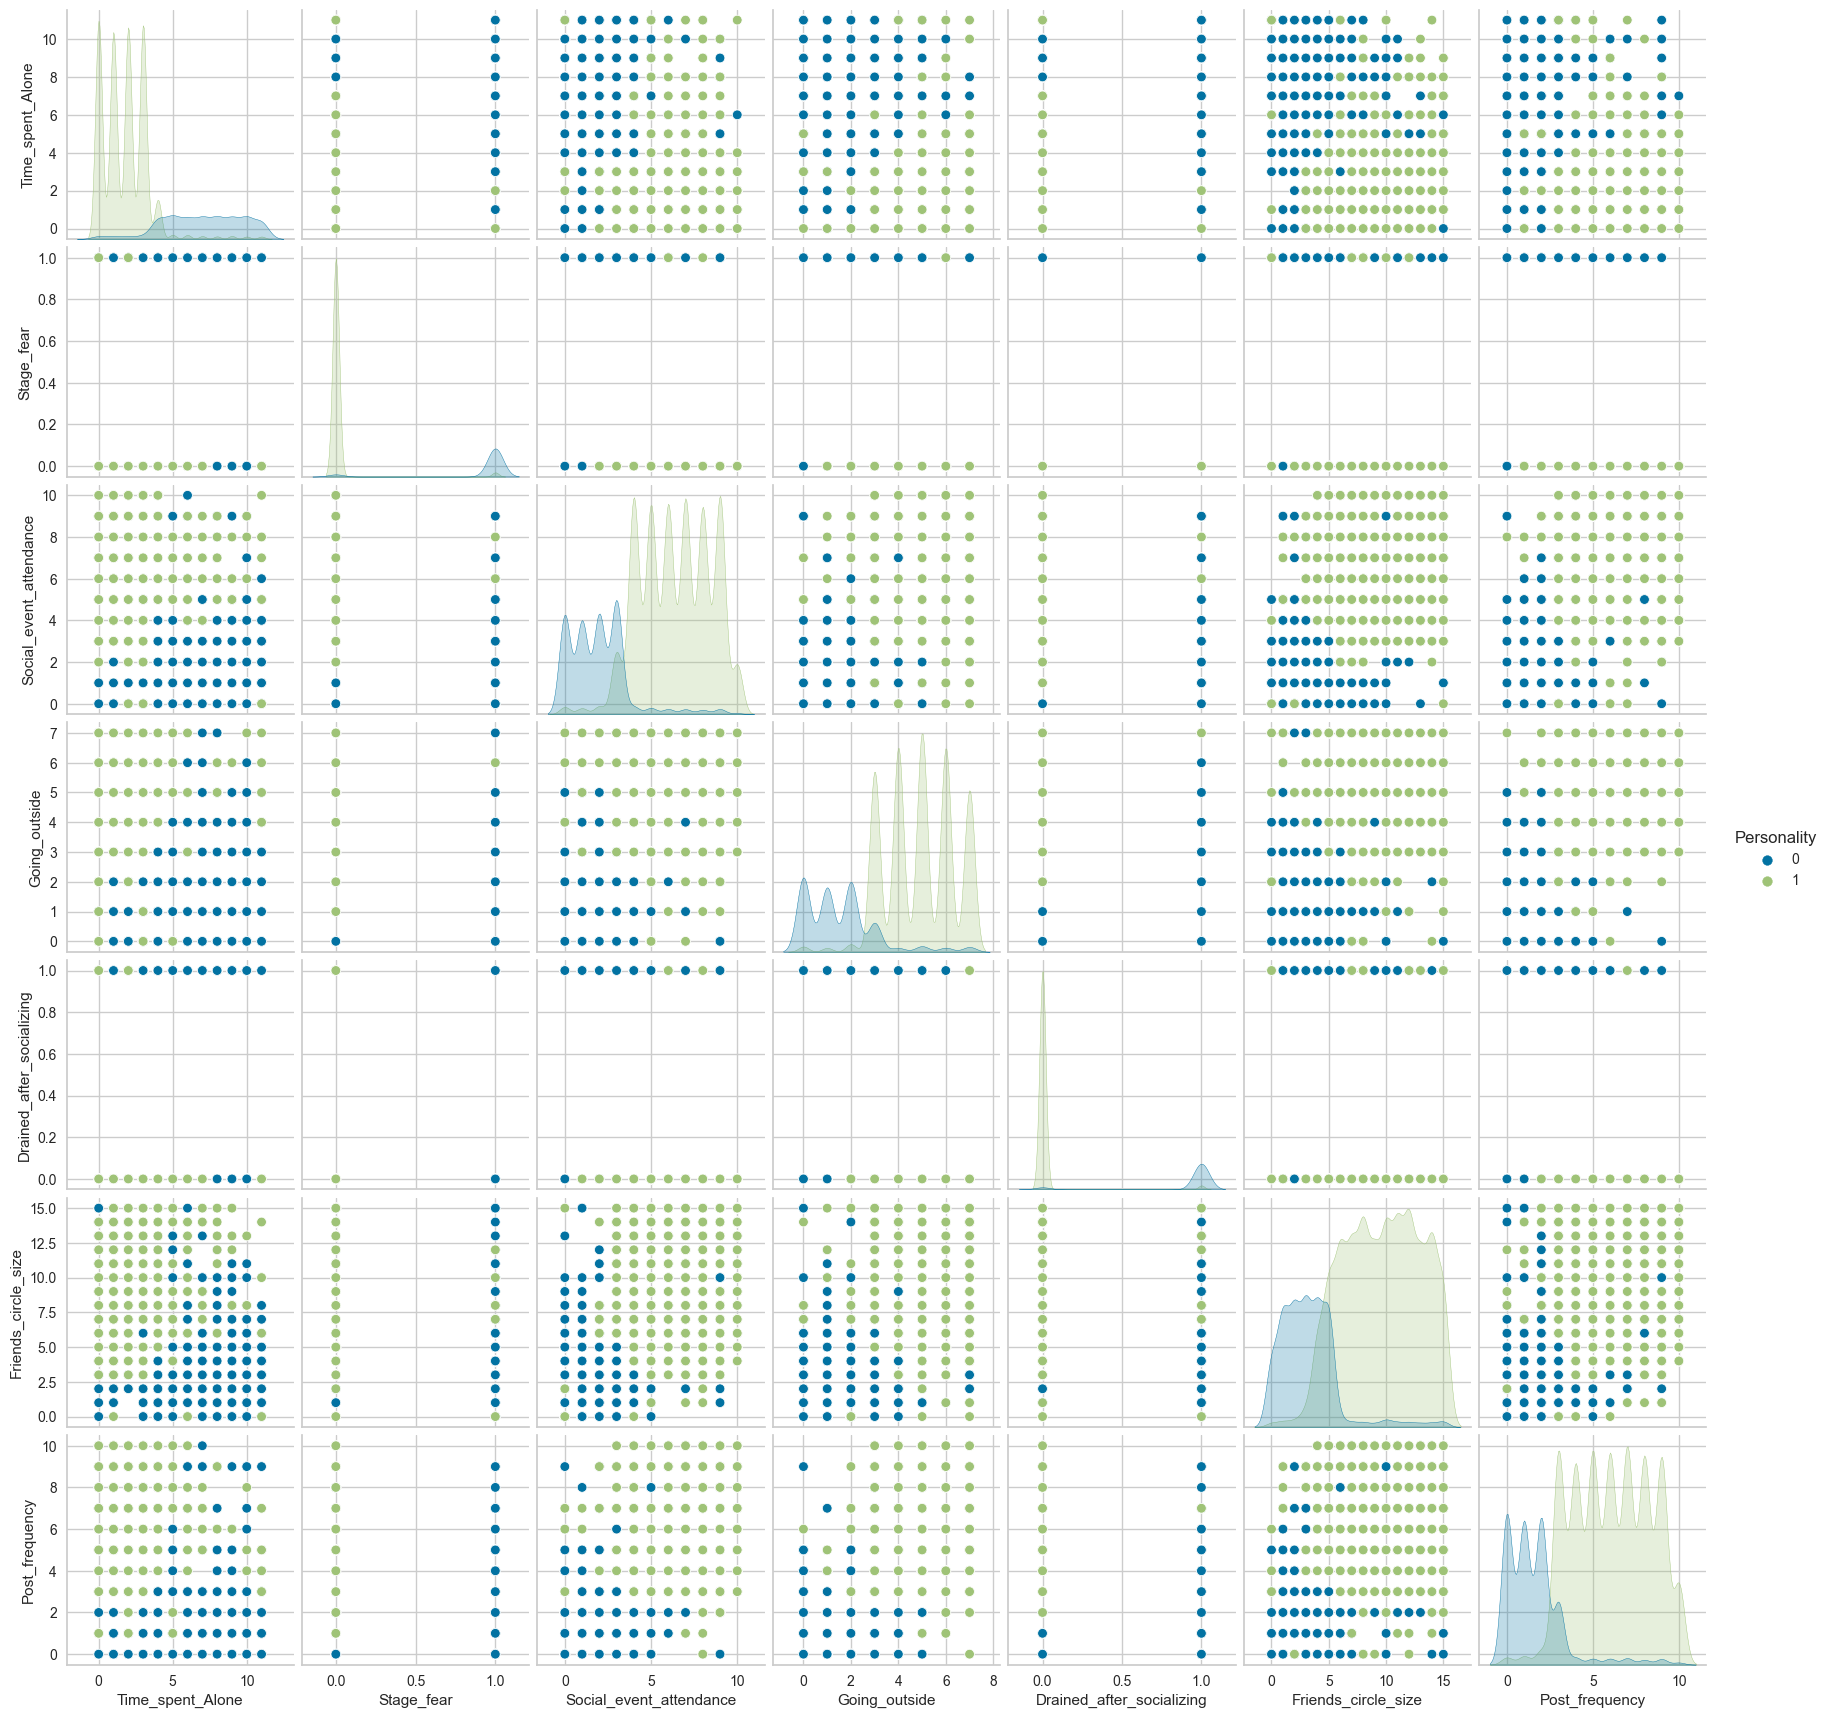

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.pairplot(df_train, hue='Personality')
plt.show()

## 2. Data Preparation

### 2.1 Balancing dataframe

In [43]:
df_train['Personality'].value_counts()

Personality
1    13699
0     4825
Name: count, dtype: int64

In [44]:
from sklearn.preprocessing import MinMaxScaler

df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

 # Apply Minmax Scaler
scaler = MinMaxScaler()
num_cols = df_train_scaled.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('Personality')  # Exclude target variable
df_train_scaled[num_cols] = scaler.fit_transform(df_train_scaled[num_cols])
df_test_scaled[num_cols] = scaler.fit_transform(df_test_scaled[num_cols])

In [45]:
# Copy of dataframes without NaN values
df_train_no_nan = df_train.dropna()
df_test_no_nan = df_test.dropna()
df_train_no_nan_scaled = df_train_scaled.dropna()
df_test_no_nan_scaled = df_test_scaled.dropna()
# Print total NaN values dropped
print(f"Total rows with NaN deleted: {df_train.shape[0] - df_train_no_nan.shape[0]}")

Total rows with NaN deleted: 8335


## 3. Models Comparison

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### 3.0 Util functions

In [47]:
# training function with cross-validation

import logging
from sklearn.model_selection import cross_val_score

logger = logging.getLogger(__name__)


def train_with_crossval(
    model,
    X_train,
    y_train,
    cv_folds=5,
    scoring="f1",
    pos_label=0,
    early_stopping_rounds=50,
    enable_logging=True
):
    model_name = type(model).__name__

    if enable_logging:
        logger.info(f"Training model: {model_name}")

    # ---- Case A: XGBoost models ----
    if hasattr(model, "get_xgb_params"):
        if enable_logging:
            logger.info("Detected XGBoost model. Running xgb.cv")

        params = model.get_xgb_params()

        dtrain = xgb.DMatrix(
            X_train.values,
            label=y_train.values
        )

        n_estimators = model.get_params().get("n_estimators", 100)
        if n_estimators is None:
            n_estimators = 100

        n_estimators = model.get_params().get("n_estimators", 100)
        if n_estimators is None:
            n_estimators = 100

        cv_result = xgb.cv(
            params,
            dtrain,
            num_boost_round=n_estimators,
            nfold=cv_folds,
            early_stopping_rounds=early_stopping_rounds,
            metrics="error",
            verbose_eval=False
        )

        best_n_estimators = cv_result.shape[0]
        model.set_params(n_estimators=best_n_estimators)

        if enable_logging:
            logger.info(f"Best n_estimators set to {best_n_estimators}")

    # ---- Case B: sklearn models ----
    else:
        if enable_logging:
            logger.info("Detected sklearn model. Running cross_val_score")

        cv_scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv_folds,
            scoring=scoring
        )

        if enable_logging:
            logger.info(
                f"CV mean {scoring}: {cv_scores.mean():.3f} "
                f"(± {cv_scores.std():.3f})"
            )

    # ---- Final training ----
    model.fit(X_train, y_train)

    if enable_logging:
        logger.info(f"Final training completed for {model_name}")

    return model


In [48]:
# Train with bagging classifiers
def baggingModel(model, X_train, y_train, bag_n_estimators=10, random_state=42, model_name='model'):
    bagging_clf = BaggingClassifier(
        estimator=model,
        n_estimators=bag_n_estimators,
        random_state=random_state
    )
    bagging_clf.fit(X_train, y_train)
    
    return (bagging_clf)


In [49]:
# Metrics function
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)

def get_metrics(
    y_true,
    y_pred,
    y_proba=None,
    pos_label=0
):
    # Confusion matrix with fixed label order
    labels = [pos_label, 1 - pos_label]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    tp, fn, fp, tn = cm.ravel()

    # Presence of positive class in predictions
    pos_label_present_in_pred = (tp + fp) > 0

    # Core metrics (safe)
    precision = precision_score(
        y_true, y_pred, pos_label=pos_label, zero_division=0
    )
    recall = recall_score(
        y_true, y_pred, pos_label=pos_label, zero_division=0
    )
    f1 = f1_score(
        y_true, y_pred, pos_label=pos_label, zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)

    # Optional ROC AUC
    roc_auc = None
    if y_proba is not None:
        if len(set(y_true)) == 2:
            roc_auc = roc_auc_score(
                y_true == pos_label,
                y_proba
            )

    return {
        "f1": round(f1, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "accuracy": round(accuracy, 3),

        "tp": int(tp),
        "fp": int(fp),
        "tn": int(tn),
        "fn": int(fn),

        "pos_label_present_in_pred": pos_label_present_in_pred,
        "roc_auc": None if roc_auc is None else round(roc_auc, 3)
    }



In [50]:
# Model validation function
def validate_model(
    model,
    variant,
    X_val,
    y_val,
    pos_label=0,
    use_proba=False,
    threshold=None,
    name="Model"
):
    # Infer model name
    model_name = name

    # Base prediction (always available)
    y_pred = model.predict(X_val)

    y_proba = None
    if use_proba:
        if not hasattr(model, "predict_proba"):
            raise AttributeError(
                f"{model_name} does not support predict_proba"
            )

        if threshold is not None and not (0.0 <= threshold <= 1.0):
            raise ValueError("threshold must be between 0 and 1")

        y_proba = model.predict_proba(X_val)[:, pos_label]

        if threshold is not None:
            y_pred = (y_proba >= threshold).astype(int)

    # Compute metrics (delegated)
    metrics = get_metrics(
        y_true=y_val,
        y_pred=y_pred,
        y_proba=y_proba,
        pos_label=pos_label
    )

    return {
        "model_name": model_name,
        "variant": variant,
        "n_samples": len(y_val),
        "prediction_mode": {
            "used_proba": use_proba,
            "threshold": threshold
        },
        "metrics": metrics
    }


In [51]:
# Balance classes with oversampling
from imblearn.combine import SMOTEENN
def balance_classes(X, y):
    imp = SMOTEENN(sampling_strategy='auto')
    X_bal, y_bal = imp.fit_resample(X,y)

    return X_bal, y_bal

In [52]:
# Main function to run models and datasets comparison
estimators = {
    'LogisticRegression' : LogisticRegression(),
    'SVC' : SVC(),
    'LinearSVC' : LinearSVC(),
    'SGD' : SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
    'KNN' : KNeighborsClassifier(),
    'DecisionTreeClf' : DecisionTreeClassifier(),
    'RandomTreeForest' : RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBClassifier' : XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)
}

def run_models_comparisson(dataframe, 
                           variant='Variant', 
                           estimators=estimators, 
                           target_col='Personality', 
                           test_size=0.35, 
                           random_state=1, 
                           balance_data=False):

    x = dataframe.drop([target_col], axis=1)
    y = dataframe[target_col]  

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    # Apply balancing if needed
    if balance_data:
        x_train, y_train = balance_classes(x_train, y_train)
        variant = variant + "_balanced"

    results_list = []

    for name, model in estimators.items():
        # Train the model with cross-validation
        trained_model = train_with_crossval(
            model,
            x_train,
            y_train,
            cv_folds=5,
            scoring="f1",
            pos_label=0,
            early_stopping_rounds=50,
            enable_logging=False
        )

        # Validate the model
        results = validate_model(
            trained_model,
            variant,
            x_test,
            y_test,
            pos_label=0,
            use_proba=False,
            threshold=None,
            name=name
        )

        # Prepare row for metrics results dataframe
        model_name = name
        row = {
            'model': results['model_name'],
            'variant': results['variant'],
            'n_samples': results['n_samples']
        }
        # Add all metrics to row
        row.update(results['metrics'])
        results_list.append(row)

        # Train the model with bagging
        bagged_model = baggingModel(
            model,
            x_train,
            y_train,
            bag_n_estimators=10,
            model_name=model_name)
        
         # Validate the model with bagging
        results = validate_model(
            bagged_model,
            variant,
            x_test,
            y_test,
            pos_label=0,
            use_proba=False,
            threshold=None
        )

        # Prepare row for metrics results dataframe
        row = {
            'model': 'bagging ' + model_name,
            'variant': results['variant'],
            'n_samples': results['n_samples']
        }
        # Add all metrics to row
        row.update(results['metrics'])
        results_list.append(row)
    
    return pd.DataFrame(results_list)

### 3.1 Binary clasification models

In [53]:
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.metrics import precision_score, recall_score, f1_score

In [54]:
train = run_models_comparisson(
    df_train, 'df_train', estimators= {
    'DecisionTreeClf' : DecisionTreeClassifier(),
    'RandomTreeForest' : RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBClassifier' : XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42),
    'XGBClassifier_2' : XGBClassifier(
        learning_rate =0.0015,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        eval_metric='error',
        random_state=42
    )
    }
)

In [55]:
train_scaled = run_models_comparisson(
    df_train_scaled, 'df_train_scaled', estimators= {
    'DecisionTreeClf' : DecisionTreeClassifier(),
    'RandomTreeForest' : RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBClassifier' : XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)
    }
)

In [56]:
train_no_nan = run_models_comparisson(
    df_train_no_nan, 'df_train_no_nan', estimators= {
    'LogisticRegression' : LogisticRegression(),
    'SVC' : SVC(),
    'LinearSVC' : LinearSVC(),
    'SGD' : SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
    'KNN' : KNeighborsClassifier(),
    'DecisionTreeClf' : DecisionTreeClassifier(),
    'RandomTreeForest' : RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBClassifier' : XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)
    },
        balance_data=True
)


In [57]:
train_no_nan_scaled = run_models_comparisson(
    df_train_no_nan_scaled, 'df_train_no_nan_scaled', estimators= {
        'LogisticRegression' : LogisticRegression(),
        'SVC' : SVC(),
        'LinearSVC' : LinearSVC(),
        'SGD' : SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
        'KNN' : KNeighborsClassifier(),
        'DecisionTreeClf' : DecisionTreeClassifier(),
        'RandomTreeForest' : RandomForestClassifier(n_estimators=50, random_state=42),
        'XGBClassifier' : XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)
    },
        balance_data=True                   
)

#### Comparisson Table

In [66]:
# Combine results from all variants
comparison_table = pd.concat([train, train_scaled, train_no_nan, train_no_nan_scaled], ignore_index=True)

# Show the table
comparison_table.sort_values(by=['f1'], ascending=False).head(10)

,model,variant,n_samples,f1,precision,recall,accuracy,tp,fp,tn,fn,pos_label_present_in_pred,roc_auc
5,bagging XGBClassifier,df_train,6484,0.941,0.940,0.942,0.970,1569,101,4718,96,True,None
13,bagging XGBClassifier,df_train_scaled,6484,0.941,0.940,0.942,0.970,1569,101,4718,96,True,None
4,XGBClassifier,df_train,6484,0.940,0.937,0.942,0.969,1569,106,4713,96,True,None
12,XGBClassifier,df_train_scaled,6484,0.940,0.937,0.942,0.969,1569,106,4713,96,True,None
11,bagging RandomTreeForest,df_train_scaled,6484,0.939,0.936,0.941,0.968,1567,107,4712,98,True,None
3,bagging RandomTreeForest,df_train,6484,0.939,0.937,0.941,0.969,1567,106,4713,98,True,None
10,RandomTreeForest,df_train_scaled,6484,0.935,0.932,0.938,0.967,1562,114,4705,103,True,None
2,RandomTreeForest,df_train,6484,0.934,0.930,0.938,0.966,1561,117,4702,104,True,None
1,bagging DecisionTreeClf,df_train,6484,0.926,0.921,0.930,0.962,1549,132,4687,116,True,None
9,bagging DecisionTreeClf,df_train_scaled,6484,0.925,0.920,0.930,0.961,1548,134,4685,117,True,None


## 3. Conclusion

The highest score is reached by XGBoost using Bagging, having the same results with scaled and non scaled values and with NaN inplace, then we can use df_train without transformations an get an accuracy of: 0.97

In [59]:
# Save bagging XGBClassifier_error model

bagged_xgb_model = baggingModel(
    XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42),
    df_train.drop(['Personality'], axis=1),
    df_train['Personality'],
    bag_n_estimators=10,
    model_name='XGBClassifier')


In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, roc_auc_score

## 4. Validating the best model with new dataset

In [61]:
df_test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,0.0,7.0,4.0,0.0,6.0,NaN
1,18525,NaN,1.0,0.0,0.0,1.0,5.0,1.0
2,18526,3.0,0.0,5.0,6.0,0.0,15.0,9.0
3,18527,3.0,0.0,4.0,4.0,0.0,5.0,6.0
4,18528,9.0,1.0,1.0,2.0,1.0,1.0,1.0


In [62]:
# Testing on validation set
x_val = df_test.drop('id', axis=1)
i_val = df_test['id']

y_val_pred = bagged_xgb_model.predict(x_val)

label_map = {
    0: 'Introvert',
    1: 'Extrovert'
}

y_val_pred_labels = [label_map[p] for p in y_val_pred]


## 5. Saving submission file

In [63]:
# Prepare csv file to submit predictions, id, 'Personality' columns
submission_df = pd.DataFrame({
    'id': i_val,
    'Personality': y_val_pred_labels
})
# save as .csv
submission_df.to_csv('submission.csv', index=False)

## 6. Saving Model

In [70]:
# Save model with pickle
import pickle as pkl
import os

with open('./models/model.pkl', 'wb') as f:
    pkl.dump(bagged_xgb_model, f)